# Model Interpretation

This notebook is used for learning how the models work and which features are the most important for the predictions.

## Imports and Global Settings

In [1]:
# Basic Data Science
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Advanced EDA
# Model Setup
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
# NLP sub-modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Model Results and Metrics
from sklearn.metrics import (RocCurveDisplay, PrecisionRecallDisplay,
                             confusion_matrix, classification_report)
# Model Interpretation Libraries
import eli5
import shap
shap.initjs()
# Global pandas and matplotlib options
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

## Helper Functions

In [3]:
def quick_model_metrics(fitted_model, X_train, y_train, X_test, y_test):
    """
    Model accuracy vs baseline (majority class - Not Fraud)
    for training and testing datasets.

    Args:
        fitted_model (object)
        X_train (dataframe)
        y_train (dataframe)
        X_test (series)
        y_test (series)
    """
    train_baseline = y_train[y_train == "Not Fraud"].size / y_train.size
    test_baseline = y_test[y_test == "Not Fraud"].size / y_test.size
    train_accuracy = fitted_model.score(X_train, y_train)
    test_accuracy = fitted_model.score(X_test, y_test)
    print(f"Train Baseline: {train_baseline:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Baseline: {test_baseline:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [4]:
def save_fitted_model(model, filename):
    """
    Save fitted model to models folder in pickle format.

    Args:
        model (object): Fitted model
        filename (string): Model name
    """
    filepath = f"../models/{filename}.pkl"
    with open(filepath, "wb") as file:
        pkl.dump(model, file)
    print("Model saved successfully.")

In [5]:
def text_to_predict_proba(X_train, y_train, X_test, features_to_convert):
    """
    Converts text features to predict_proba of fraud.
    Trains the model each time to specific inputted
    train test split to avoid any possible data leakage.
    Time consuming at scale.

    Args:
        X_train (dataframe)
        y_train (series)
        X_test (dataframe)
        features_to_convert (list of strings):
            List of text feature names to model
            and convert to probability of fraud.

    Returns:
        tuple of dataframes: X_train, X_test
    """
    train = X_train
    test = X_test
    for feature in features_to_convert:
        text_clf_pipeline = Pipeline(
            [
                (
                    "vect",
                    CountVectorizer(ngram_range=(1, 2), stop_words="english"),
                ),
                ("tfidf", TfidfTransformer()),
                (
                    "clf",
                    SGDClassifier(loss="modified_huber", max_iter=10000),
                ),
            ]
        )
        text_clf_pipeline.fit(train[feature], y_train)
        fraud_index = np.argwhere(text_clf_pipeline.classes_ == "Fraud")[0, 0]
        for dataset in [train, test]:
            predictions = text_clf_pipeline.predict_proba(dataset[feature])[
                :, fraud_index
            ]
            dataset[f"{feature}_proba"] = predictions
            dataset.drop(columns=feature, inplace=True)
    return train, test

In [6]:
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# https://github.com/DTrimarchi10/confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [7]:
def make_model_metrics_graphs(y_test, y_pred, save=False, model_type=None):
    # Data Setup
    cf_matrix = confusion_matrix(y_test, y_pred, labels=['Not Fraud', 'Fraud'])
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=['Not Fraud', 'Fraud']).ravel()
    print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = round(clf_report['accuracy'], 4) * 100
    weighted_avg_recall = round(clf_report['weighted avg']['recall'], 4) * 100
    weighted_avg_precision = round(clf_report['weighted avg']['precision'], 4) * 100
    weighted_avg_f1_score = round(clf_report['weighted avg']['f1-score'], 4) * 100
    fraud_recall = round(clf_report['Fraud']['recall'], 4) * 100
    fraud_precision = round(clf_report['Fraud']['precision'], 4) * 100
    fraud_f1_score = round(clf_report['Fraud']['f1-score'], 4) * 100
    sns.set(font='sans-serif', style='white')
    # Graphing
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    # Confusion Matrix
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    categories = categories = ['Not Fraud', 'Fraud']
    ax1 = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',
                      ax=ax1, cbar=False, annot_kws={"size": 18},
                      linewidths=1, linecolor="grey", vmax=300)

    ax1.set_title('Confusion Matrix', fontsize=24, pad=10)

    ax1.set_xlabel('Predicted Label', fontsize=18)
    ax1.yaxis.labelpad = 14
    ax1.xaxis.set_ticklabels(categories, fontsize=16)

    ax1.set_ylabel('True Label', fontsize=18)
    ax1.xaxis.labelpad = 14
    ax1.yaxis.set_ticklabels(categories, fontsize=16, va="center")

    # Metrics
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax2.annotate('{:.0f}%'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=16)

    x = np.arange(4)
    labels = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
    rects1 = ax2.bar(x, [accuracy, 0, 0, 0], color = '#08306b', width = 0.8)
    rects2 = ax2.bar(x - 0.2, [0, weighted_avg_recall, weighted_avg_precision, weighted_avg_f1_score],
            color = '#08306b', width = 0.4, label="Overall")
    rects3 = ax2.bar(x + 0.2, [0, fraud_recall, fraud_precision, fraud_f1_score],
            color = 'r', width = 0.4, label="Fraud")

    ax2.set_title("Model Metrics", fontsize=24, pad=10)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    ax2.set_ylim(0, 105)
    ax2.legend(fontsize=16, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)

    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, fontsize=16)
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.set_yticklabels([], fontsize=16)

    fig.tight_layout(pad=2)
    
    if save:
          plt.savefig(f'../images/{model_type}_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()   
    

In [8]:
def make_model_results_curves(X_test, X_test_scaled, y_test, models, save=False, filename=None):
    sns.set(font='sans-serif', style='whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    # ROC Plot
    random_chance = ax1.plot([0,1], [0,1], color='black', linestyle='--')
    for model_name, fitted_model in models.items():
        if model_name == 'Logistic Regression':
            RocCurveDisplay.from_estimator(fitted_model, X_test_scaled, y_test, ax=ax1,
                       name=model_name, pos_label="Fraud")
        else:
            RocCurveDisplay.from_estimator(fitted_model, X_test, y_test, ax=ax1,
                       name=model_name, pos_label="Fraud") 
    ax1.set_title("ROC Curve", fontsize=24, pad=10)
    ax1.set_xlabel('False Positive Rate', fontsize=18)
    ax1.xaxis.labelpad = 14
    ax1.set_ylabel('True Positive Rate', fontsize=18)
    ax1.yaxis.labelpad = 14
    ax1.legend(fontsize=16)
    # Precision/Recall Plot
    for model_name, fitted_model in models.items():
        if model_name == 'Logistic Regression':
            PrecisionRecallDisplay.from_estimator(fitted_model, X_test_scaled, y_test, ax=ax2,
                       name=model_name, pos_label="Fraud")
        else:
            PrecisionRecallDisplay.from_estimator(fitted_model, X_test, y_test, ax=ax2,
                                        name=model_name, pos_label="Fraud")
    ax2.set_title("Precision-Recall Curve", fontsize=24, pad=10)
    ax2.set_xlabel('Recall', fontsize=18)
    ax2.xaxis.labelpad = 14
    ax2.set_ylabel('Precision', fontsize=18)
    ax2.yaxis.labelpad = 14
    ax2.legend(fontsize=16)
    fig.tight_layout(pad=2)
    if save:
              plt.savefig(f'../images/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Load Data

In [2]:
# Import the data prep pipeline
import sys
sys.path.append('..')
from src.data.preprocessing import load_fraud_data, run_data_prep_pipeline

# Load and process both training and test data (chronological split)
train_data = load_fraud_data("train_data")
test_data = load_fraud_data("test_data")



df_train = run_data_prep_pipeline(train_data)
print(f"Training data: {len(df_train)} records (2007-mid-2013)")

df_test = run_data_prep_pipeline(test_data)
print(f"Test data: {len(df_test)} records (mid-2013)")

Training data: 8602 records (2007-mid-2013)
Test data: 2867 records (mid-2013)
Test data: 2867 records (mid-2013)


## Model Setup

In [9]:
all_possible_features = [
        "approx_payout_date", "body_length", "channels", "country",
        "currency", "delivery_method", "description", "email_domain",
        "event_created", "event_end", "event_published", "event_start",
        "fb_published", "gts", "has_analytics", "has_header", "has_logo",
        "listed", "name", "name_length", "num_order", "num_payouts",
        "object_id", "org_desc", "org_facebook", "org_name", "org_twitter",
        "payee_name", "payout_type", "sale_duration", "sale_duration2",
        "show_map", "user_age", "user_created", "user_type", "venue_address",
        "venue_country", "venue_latitude", "venue_longitude", "venue_name",
        "venue_state", "num_previous_payouts", "previous_payouts_total",
        "num_ticket_types", "num_tickets_available", "total_ticket_value",
        "avg_ticket_cost", "known_payee_name", "known_venue_name",
        "known_payout_type", "total_empty_values", "name_proba",
        "description_proba", "org_name_proba", "org_desc_proba"
        ]

features_to_test = [
        "body_length", "channels", "delivery_method", "fb_published",
        "gts", "has_analytics", "has_header", "has_logo", "listed",
        "name_length", "num_order", "num_payouts", "org_facebook",
        "org_twitter", "user_type", "sale_duration", "sale_duration2",
        "show_map", "user_age", "venue_latitude", "venue_longitude",
        "num_previous_payouts", "previous_payouts_total",
        "num_ticket_types", "num_tickets_available", "total_ticket_value",
        "avg_ticket_cost", "known_payee_name", "known_venue_name",
        "known_payout_type", "total_empty_values", "name", "description",
        "org_name", "org_desc"
        ]

In [10]:
# Use chronological train/test split (no random splitting)
X_train = df_train[features_to_test]
y_train = df_train['is_fraud']
X_test = df_test[features_to_test]
y_test = df_test['is_fraud']


print(f"X_train shape: {X_train.shape}")
print(f"Test fraud rate: {(y_test == 'Fraud').sum() / len(y_test) * 100:.2f}%")

print(f"X_test shape: {X_test.shape}")
print(f"Train fraud rate: {(y_train == 'Fraud').sum() / len(y_train) * 100:.2f}%")

X_train shape: (8602, 35)
Test fraud rate: 4.43%
X_test shape: (2867, 35)
Train fraud rate: 9.56%


## NLP Feature Engineering

In [11]:
X_train, X_test = text_to_predict_proba(X_train, y_train, X_test, ["name", "description",
        "org_name", "org_desc"])
features_to_test = list(X_train.columns)

/tmp/ipykernel_370237/3311350343.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f"{feature}_proba"] = predictions
/tmp/ipykernel_370237/3311350343.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns=feature, inplace=True)
/tmp/ipykernel_370237/3311350343.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

## Scale Data

In [12]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train, copy=True)
X_test_scaled = scaler.transform(X_test, copy=True)

### Model Parameters

In [13]:
models = {"log_reg": LogisticRegression, "forest": RandomForestClassifier, "xgboost": None}

In [14]:
log_reg_best_params = dict(
    penalty="l2",
    C=1,
    class_weight='balanced',
    random_state=7,
    solver="newton-cg",
    max_iter=10000,
    tol=0.0001,
    l1_ratio=None,
)

forest_best_params = dict(random_state=7)

xgboost_best_params = dict()

### Logistic Regression

In [15]:
log_reg_clf = models['log_reg'](**log_reg_best_params)

In [16]:
log_reg_clf.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,7
,solver,'newton-cg'
,max_iter,10000
,multi_class,'deprecated'


In [17]:
log_reg_pred = log_reg_clf.predict(X_test_scaled)

In [18]:
# save_fitted_model(log_reg_clf, 'log_reg_clf')

### Random Forest Classifier

**Production Threshold Optimization:** The classification threshold has been optimized from the default 0.5 to **0.10** to maximize fraud detection in alignment with business requirements. This threshold prioritizes catching fraudulent events (high recall) over minimizing false positives.

In [19]:
forest_clf = models['forest'](**forest_best_params)

In [20]:
forest_clf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
# Use optimized threshold for production deployment
# Threshold of 0.10 maximizes fraud detection (recall ~90%) while maintaining acceptable precision
threshold = 0.10
forest_pred_proba = forest_clf.predict_proba(X_test)[:, 0]  # Fraud is class 0
forest_pred = np.where(forest_pred_proba >= threshold, 'Fraud', 'Not Fraud')

In [22]:
save_fitted_model(forest_clf, 'forest_clf')

Model saved successfully.


In [23]:
# forest_param_grid = dict(n_estimators=[10, 50, 100, 500],
#                           criterion=['gini', 'entropy'],
#                           max_depth=[10, 100, None],
#                           max_features=[5, 25, 'auto'],
#                           max_leaf_nodes=[10, 100, None],
#                           class_weight=[None, 'balanced'],
#                           random_state=[7],
#                           verbose=[1],
#                           n_jobs=[None])

# forest_cv_clf = GridSearchCV(RandomForestClassifier(), forest_param_grid)

In [24]:
# forest_cv_clf.fit(X_train, y_train)

In [25]:
# forest_cv_clf.best_params_

In [26]:
# forest_cv_clf.best_score_

In [27]:
# forest_cv_clf.best_estimator_

## Model Results

In [28]:
quick_model_metrics(
        forest_clf,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

Train Baseline: 0.9044
Train Accuracy: 1.0000
Test Baseline: 0.9557
Test Accuracy: 0.9655


### Classification Report

In [29]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

       Fraud       0.45      0.87      0.60       127
   Not Fraud       0.99      0.95      0.97      2740

    accuracy                           0.95      2867
   macro avg       0.72      0.91      0.78      2867
weighted avg       0.97      0.95      0.96      2867



### Confusion Matrix

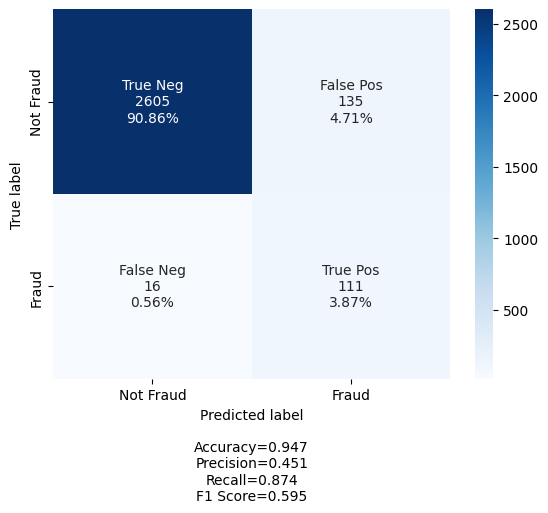

In [30]:
cf_matrix = confusion_matrix(y_test, forest_pred, labels=['Not Fraud', 'Fraud'])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Not Fraud', 'Fraud']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### ROC Curve

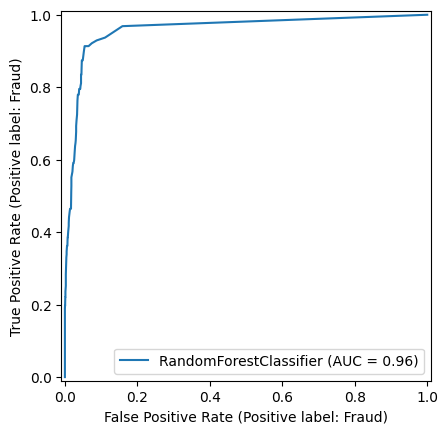

In [31]:
RocCurveDisplay.from_estimator(forest_clf, X_test, y_test, pos_label="Fraud")

### Precision - Recall Curve

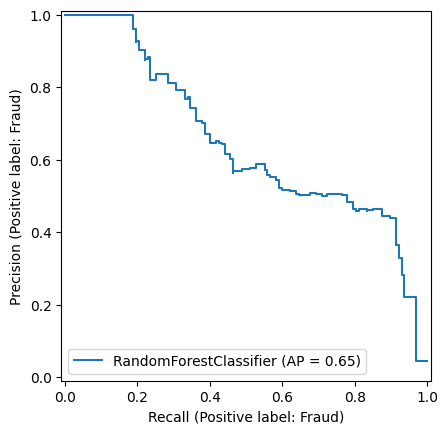

In [32]:
PrecisionRecallDisplay.from_estimator(forest_clf, X_test, y_test, pos_label="Fraud")

## Readme Model Results

### Metrics and Confusion Matrix

TN: 2605, FP: 135, FN: 16, TP: 111


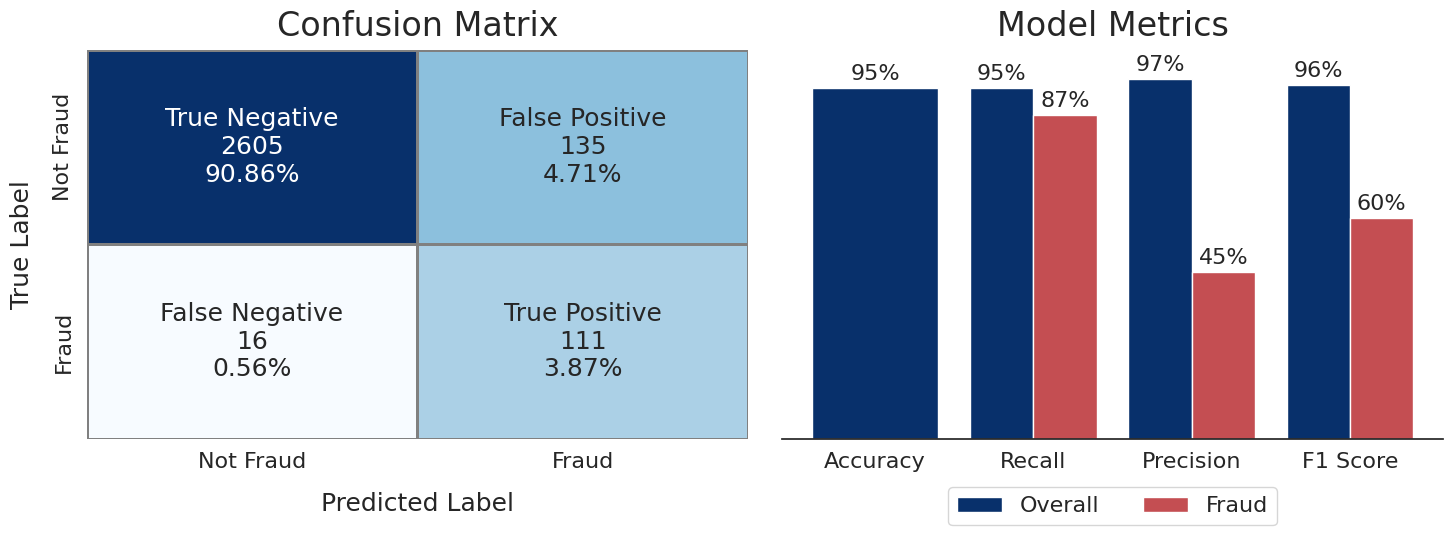

In [33]:
make_model_metrics_graphs(y_test, forest_pred, save=True, model_type='forest')

### ROC Curve and Precision/Recall Curve

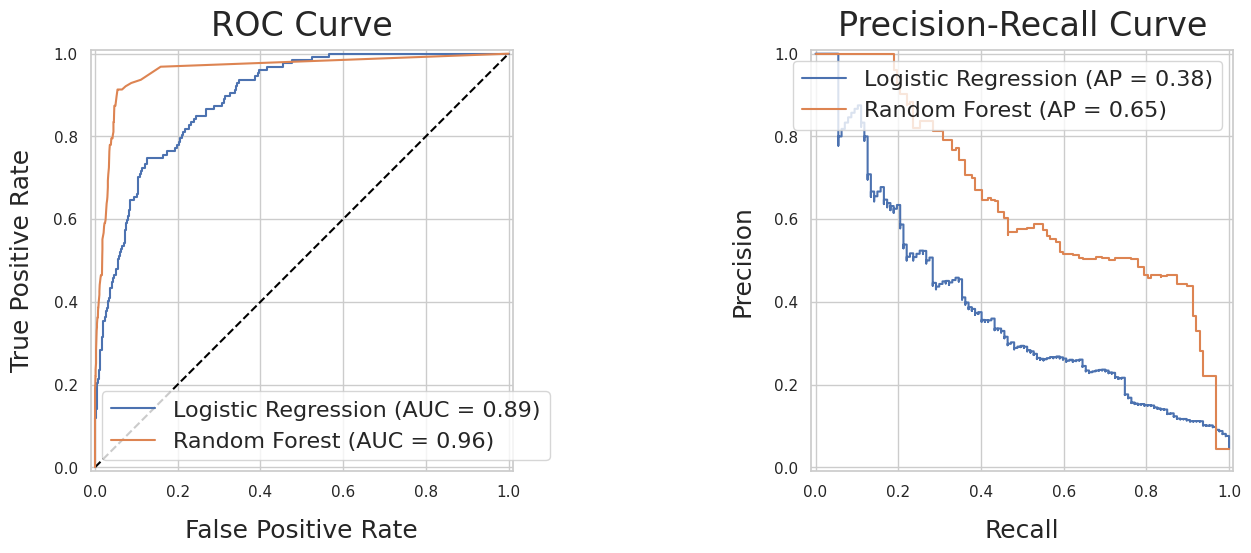

In [34]:
model_curve_dict = {'Logistic Regression': log_reg_clf, 'Random Forest': forest_clf}
make_model_results_curves(X_test, X_test_scaled, y_test, model_curve_dict, save=True, filename='model_comparison_curves')

## Save Model

In [35]:
# model_name_to_save = "_test_1"
# save_fitted_model(clf, model_name_to_save)

## Load Model

In [36]:
# model_name_to_load = "_test_"

# clf = None
# with open(f"../models/{model_name_to_load}.pkl", "rb") as f:
#     clf = pkl.load(f)

## Model Interpretation

### eli5 - Feature Weights

In [37]:
eli5.show_weights(forest_clf, feature_names = features_to_test, 
                  top=None, show=['targets', 'method', 'description',
                                  'decision_tree', 'feature_importances'])

Weight,Feature
0.2873 ± 0.6973,name_proba
0.1760 ± 0.4878,description_proba
0.1199 ± 0.3994,org_name_proba
0.1131 ± 0.4134,num_previous_payouts
0.0930 ± 0.3606,previous_payouts_total
0.0444 ± 0.1783,org_desc_proba
0.0344 ± 0.1755,sale_duration
0.0281 ± 0.1576,total_empty_values
0.0188 ± 0.1068,known_payout_type
0.0168 ± 0.1032,sale_duration2


### SHAP - Feature "Importances"

In [38]:
explainer = shap.Explainer(forest_clf, X_train, feature_names=features_to_test)
shap_values = explainer(X_test)

 94%|=================== | 5365/5734 [00:14<00:00]       

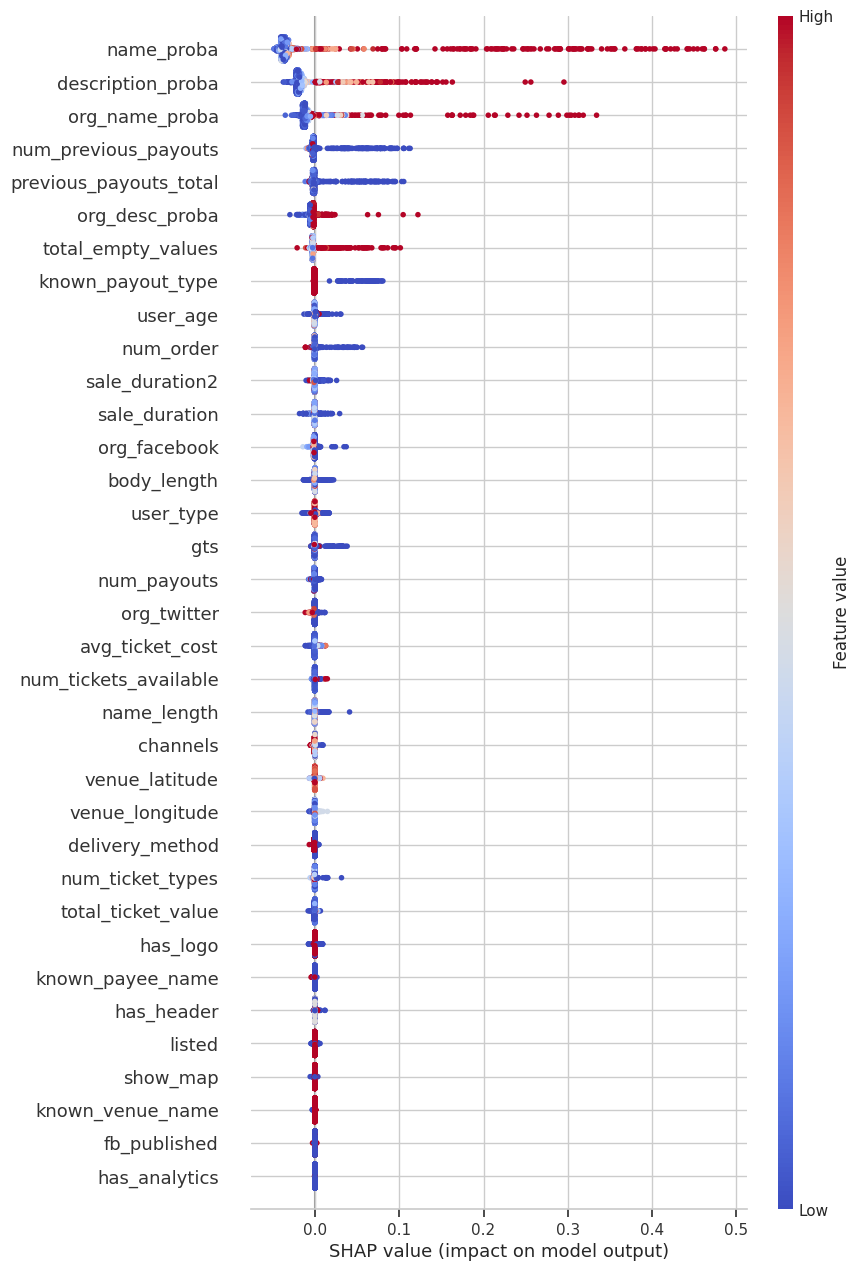

In [39]:
# For multi-class models, we need to select the class-specific SHAP values
# Index 0 corresponds to 'Fraud' class (the positive class we care about)
shap.plots.beeswarm(shap_values[:,:,0], max_display=None, color=plt.get_cmap("coolwarm"))

### Individual Prediction Explanation

Not Fraud


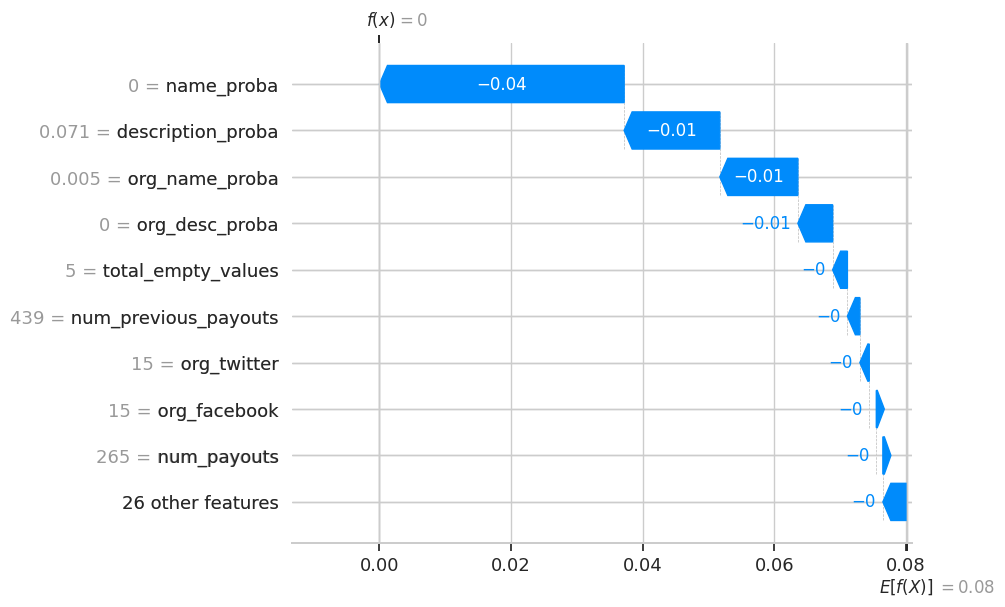

In [40]:
index_num = 7

print(f'{y_test.iloc[index_num]}')
# For multi-class models, select the Fraud class (index 0)
shap.plots.waterfall(shap_values[index_num, :, 0])